# A Self-Connected Cluster of N-1 neurons with N-2 self connections gets an input perturbation from 1 Neuron

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook

In [2]:
TAU_TWO = 0.3
TAU_FALL= 0.45
THRESHOLD= -30.0
INCREMENT =100 

CM  = 1.00  # /*uF/cm2*/
I_APP = 0.00 # /*uA/cm2*/

E_NA =  50.0
E_K  = -90.0
E_L  = -71.975 # //-70.4
E_SYN_SH =  -55.0 #reversal potential of GABA_Asynapse - determines shunt (-55) 
E_SYN_H =  -75.0 #reversal potential of GABA_Asynapse - determines hyperpolarizing (-75) 
#E_SYN =  -75.0 #reversal potential of GABA_Asynapse - determines shunt (-55) versus hyperpolarizing (-75) 

G_NA = 218.8 # //239.13  mS/cm2 all conductances were divided by 0.000096 cm2
G_K3 =  8.225 # // 10.22469
G_K1 =  0.769 # // 1.1058
G_L  = 0.1915 # // 0.2224

#DELAY = 0.8

THETA_M = -52.995 # // -56.42
SIGMA1_M = 4.0
SIGMA2_M = -13.0
K1_M = 0.25
K2_M = 0.1

THETA_H = -55.711 # //-56.59
SIGMA1_H = -20.0
SIGMA2_H = 3.5
K1_H = 0.012
K2_H = 0.2

THETA_N = 5.9 # // -4.23
SIGMA1_N = 12.0
SIGMA2_N = -8.5
K1_N = 1.0 
K2_N = 0.001

THETA_A = 51.355 # // 51.4
SIGMA1_A = 12.0
SIGMA2_A = -80.0
K1_A = 1.0 
K2_A = 0.02

ALPHA = 6.25 # /* ms */
TAUSYN = 1.0 # /*  1.0 3.0 2.0   */
SS1 = 0.00
SS2 = 0.00
I_STIM = 0.0

#Defining some functions that are required for the routine

def boltz(V,half,slope): 
    arg = -(V-half)/slope
    if( (arg>50.0) or (arg<-50) ):
        if(arg>50):
            return(0.0)
        else:
            return(1.0)
    else:
        return(1.0/(1.0 + np.exp(arg)))

def gaussian(v,a,b,c,d):
    arg = ((v-c)/b)**2
    if( (arg>50.0) or (arg<-50) ):
        if(arg>50):
            return(d)
        else:
            return(d+a)
    else:
        return((d + a*np.exp(-arg)))

def efun(z):
    if(abs(z) < 1e-4):
        return(1 - z/2)
    else:
        return(z/(np.exp(z) - 1))
    
def alpha(v,k,theta,sigma):
    arg = (theta-v)/sigma
    if(v == theta):
        return(k*sigma)
    else:
        if( (arg>50.0) or (arg<-50) ):
            if(arg>50.0): 
                return(0.0)
            else:
                return(k*(v - theta))
        else:
            return(k*(theta-v)/(np.exp(arg) - 1.0))

def beta(v,k,sigma):
    return(k*np.exp(v/sigma))

#This function identifies the onset of a spike, the first time the threshold is crossed
def spike(x,t):
    'An event when V1 >= THRESHOLD'
    if (t == 0.0):
        return 0
    
    if (x[0] >= THRESHOLD):
        return 1
    else:
        return 0
    
#Functions for Synaptic Currents 
def I_NA(V, M, H): return G_NA * (M**3) * H * (V - E_NA)
def I_K1(V,A): return G_K1 * (A**4) * (V - E_K)
def I_L(V): return G_L * (V - E_L)
def I_K3(V,N): return G_K3 * (N**4) * (V - E_K)
def I_S1(V,gsyn1):   return gsyn1 * (V - E_SYN_SH)
def I_S2(V):   return G_SYN2 * V
def I_S3(V,G): return G * (V - E_SYN_SH)

In [3]:
def ODE_Routine(intitial_values,tf,h,delta):
    e = [spike(initial_values[0],0)]
    h2 = h/2
    N = tf/h
    N = int(N)
    end = int(N)
    t = np.linspace(0,tf,N+1)
    Autapse_Times = []
    t_autapse = -1
    gsyn1 = 0

    #Defining the State, Co-State and Control Variables as Vectors
    V = np.zeros(len(t))
    H = np.zeros(len(t))
    N = np.zeros(len(t))
    A = np.zeros(len(t))
    M = np.zeros(len(t))
    X = np.zeros(len(t))
    G = np.zeros(len(t))

    #Assigning the initial values
    V[0] = initial_values[0]
    H[0] = initial_values[1]
    N[0] = initial_values[2]
    A[0] = initial_values[3]
    M[0] = initial_values[4]
    X[0] = initial_values[5]
    G[0] = initial_values[6]
    
    sol = [initial_values]
    
    for i in range(end):
        if(round(t[i],4) == round(t_autapse,4)):
        #if(t[i] == t_autapse):
            print(t[i],t_autapse)
            X[i] = X[i] + G_SYN3  
        
        k1V = (I_STIM - I_S2(V[i]) - I_NA(V[i],M[i],H[i]) - I_K1(V[i],A[i]) - I_K3(V[i],N[i]) - I_L(V[i]) - I_S1(V[i],gsyn1) - I_S3(V[i],G[i])) / CM
        k1H = beta(V[i],K1_H,SIGMA1_H)*(1.0 - H[i]) - alpha(V[i],K2_H,THETA_H,SIGMA2_H)*H[i]
        k1N = alpha(V[i],K1_N,THETA_N,SIGMA1_N)*(1.0 - N[i]) - beta(V[i],K2_N,SIGMA2_N)*N[i]
        k1A = alpha(V[i],K1_A,THETA_A,SIGMA1_A)*(1.0 - A[i]) - beta(V[i],K2_A,SIGMA2_A)*A[i]
        k1M = alpha(V[i],K1_M,THETA_M,SIGMA1_M)*(1.0 - M[i]) - beta(V[i],K2_M,SIGMA2_M)*M[i]
        k1X = -X[i]/TAU_TWO
        k1G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * X[i]) - G[i])/TAU_FALL
        
        k2V = (I_STIM - I_S2((V[i]+h2*k1V)) - I_NA((V[i]+h2*k1V),(M[i]+h2*k1M),(H[i]+h2*k1H)) - I_K1((V[i]+h2*k1V),(A[i]+h2*k1A)) - I_K3((V[i]+h2*k1V),(N[i]+h2*k1N)) - I_L((V[i]+h2*k1V)) - I_S1((V[i]+h2*k1V),gsyn1) - I_S3((V[i]+h2*k1V),(G[i]+h2*k1G))) / CM
        k2H = beta((V[i]+h2*k1V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h2*k1H)) - alpha((V[i]+h2*k1V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h2*k1H)
        k2N = alpha((V[i]+h2*k1V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h2*k1N)) - beta((V[i]+h2*k1V),K2_N,SIGMA2_N)*(N[i]+h2*k1N)
        k2A = alpha((V[i]+h2*k1V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h2*k1A)) - beta((V[i]+h2*k1V),K2_A,SIGMA2_A)*(A[i]+h2*k1A)
        k2M = alpha((V[i]+h2*k1V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h2*k1M)) - beta((V[i]+h2*k1V),K2_M,SIGMA2_M)*(M[i]+h2*k1M)
        k2X = -(X[i]+h2*k1X)/TAU_TWO
        k2G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h2*k1X)) - (G[i]+h2*k1G))/TAU_FALL
        
        k3V = (I_STIM - I_S2((V[i]+h2*k2V)) - I_NA((V[i]+h2*k2V),(M[i]+h2*k2M),(H[i]+h2*k2H)) - I_K1((V[i]+h2*k2V),(A[i]+h2*k2A)) - I_K3((V[i]+h2*k2V),(N[i]+h2*k2N)) - I_L((V[i]+h2*k2V)) - I_S1((V[i]+h2*k2V),gsyn1) - I_S3((V[i]+h2*k2V),(G[i]+h2*k2G))) / CM
        k3H = beta((V[i]+h2*k2V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h2*k2H)) - alpha((V[i]+h2*k2V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h2*k2H)
        k3N = alpha((V[i]+h2*k2V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h2*k2N)) - beta((V[i]+h2*k2V),K2_N,SIGMA2_N)*(N[i]+h2*k2N)
        k3A = alpha((V[i]+h2*k2V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h2*k2A)) - beta((V[i]+h2*k2V),K2_A,SIGMA2_A)*(A[i]+h2*k2A)
        k3M = alpha((V[i]+h2*k2V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h2*k2M)) - beta((V[i]+h2*k2V),K2_M,SIGMA2_M)*(M[i]+h2*k2M)
        k3X = -(X[i]+h2*k2X)/TAU_TWO
        k3G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h2*k2X)) - (G[i]+h2*k2G))/TAU_FALL
        
        k4V = (I_STIM - I_S2((V[i]+h*k3V)) - I_NA((V[i]+h*k3V),(M[i]+h*k3M),(H[i]+h*k3H)) - I_K1((V[i]+h*k3V),(A[i]+h*k3A)) - I_K3((V[i]+h*k3V),(N[i]+h*k3N)) - I_L((V[i]+h*k3V)) - I_S1((V[i]+h*k3V),gsyn1) - I_S3((V[i]+h*k3V),(G[i]+h*k3G))) / CM
        k4H = beta((V[i]+h*k3V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h*k3H)) - alpha((V[i]+h*k3V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h*k3H)
        k4N = alpha((V[i]+h*k3V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h*k3N)) - beta((V[i]+h*k3V),K2_N,SIGMA2_N)*(N[i]+h*k3N)
        k4A = alpha((V[i]+h*k3V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h*k3A)) - beta((V[i]+h*k3V),K2_A,SIGMA2_A)*(A[i]+h*k3A)
        k4M = alpha((V[i]+h*k3V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h*k3M)) - beta((V[i]+h*k3V),K2_M,SIGMA2_M)*(M[i]+h*k3M)
        k4X = -(X[i]+h*k3X)/TAU_TWO
        k4G = ( ( ((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h*k3X)) - (G[i]+h*k3G))/TAU_FALL
        
        V[i+1] = V[i] + (h/6)*(k1V + 2*k2V + 2*k3V + k4V)
        H[i+1] = H[i] + (h/6)*(k1H + 2*k2H + 2*k3H + k4H)
        N[i+1] = N[i] + (h/6)*(k1N + 2*k2N + 2*k3N + k4N)
        A[i+1] = A[i] + (h/6)*(k1A + 2*k2A + 2*k3A + k4A)
        M[i+1] = M[i] + (h/6)*(k1M + 2*k2M + 2*k3M + k4M)
        X[i+1] = X[i] + (h/6)*(k1X + 2*k2X + 2*k3X + k4X)
        G[i+1] = G[i] + (h/6)*(k1G + 2*k2G + 2*k3G + k4G)
        sol+=[[V[i+1], H[i+1], N[i+1], A[i+1],M[i+1],X[i+1],G[i+1]]]
        
        e += [spike(sol[-1],t[-1])]
        if ((e[-1]==1) and (e[-2] == 0)):
            #The neuron has just crossed the threshold
            t_autapse = t[i] + delta
            Autapse_Times.append(t_autapse)
            #print('Autapse times',t_autapse)

    #print(i,sol[-1],len(sol))
    return sol

In [4]:
def ODE_Routine_Perturb(intitial_values,tf,h,ts):
    e = [spike(initial_values[0],0)]
    h2 = h/2
    N = tf/h
    N = int(N)
    end = int(N)
    t = np.linspace(0,tf,N+1)
    Autapse_Times = []
    t_autapse = -1
    

    #Defining the State, Co-State and Control Variables as Vectors
    V = np.zeros(len(t))
    H = np.zeros(len(t))
    N = np.zeros(len(t))
    A = np.zeros(len(t))
    M = np.zeros(len(t))
    X = np.zeros(len(t))
    G = np.zeros(len(t))

    #Assigning the initial values
    V[0] = initial_values[0]
    H[0] = initial_values[1]
    N[0] = initial_values[2]
    A[0] = initial_values[3]
    M[0] = initial_values[4]
    X[0] = initial_values[5]
    G[0] = initial_values[6]
    
    sol = [initial_values]
    arg = (TAU_TWO*TAU_FALL) * ((np.log(TAU_FALL/TAU_TWO))/(TAU_FALL-TAU_TWO))
    f = 1.0/(np.exp(-arg/TAU_FALL) - np.exp(-arg/TAU_TWO))
    #gsyn1 = f*G_SYN*(np.exp((ts - xp)/TAU_FALL) - np.exp((ts - xp)/TAU_TWO))
    
    for i in range(end):
        if(round(t[i],4) == round(t_autapse,4)):
        #if(t[i] == t_autapse):
            #print(t[i],t_autapse)
            X[i] = X[i] + G_SYN3  
            
        if (t[i] < ts): 
            gsyn1 = 0.0 #Allowing the first three spikes as a freely oscillating neuron 
        else:
            gsyn1 = f*G_SYN*(np.exp((ts - t[i])/TAU_FALL) - np.exp((ts - t[i])/TAU_TWO))

        
        k1V = (I_STIM - I_S2(V[i]) - I_NA(V[i],M[i],H[i]) - I_K1(V[i],A[i]) - I_K3(V[i],N[i]) - I_L(V[i]) - I_S1(V[i],gsyn1) - I_S3(V[i],G[i])) / CM
        k1H = beta(V[i],K1_H,SIGMA1_H)*(1.0 - H[i]) - alpha(V[i],K2_H,THETA_H,SIGMA2_H)*H[i]
        k1N = alpha(V[i],K1_N,THETA_N,SIGMA1_N)*(1.0 - N[i]) - beta(V[i],K2_N,SIGMA2_N)*N[i]
        k1A = alpha(V[i],K1_A,THETA_A,SIGMA1_A)*(1.0 - A[i]) - beta(V[i],K2_A,SIGMA2_A)*A[i]
        k1M = alpha(V[i],K1_M,THETA_M,SIGMA1_M)*(1.0 - M[i]) - beta(V[i],K2_M,SIGMA2_M)*M[i]
        k1X = -X[i]/TAU_TWO
        k1G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * X[i]) - G[i])/TAU_FALL
        
        k2V = (I_STIM - I_S2((V[i]+h2*k1V)) - I_NA((V[i]+h2*k1V),(M[i]+h2*k1M),(H[i]+h2*k1H)) - I_K1((V[i]+h2*k1V),(A[i]+h2*k1A)) - I_K3((V[i]+h2*k1V),(N[i]+h2*k1N)) - I_L((V[i]+h2*k1V)) - I_S1((V[i]+h2*k1V),gsyn1) - I_S3((V[i]+h2*k1V),(G[i]+h2*k1G))) / CM
        k2H = beta((V[i]+h2*k1V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h2*k1H)) - alpha((V[i]+h2*k1V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h2*k1H)
        k2N = alpha((V[i]+h2*k1V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h2*k1N)) - beta((V[i]+h2*k1V),K2_N,SIGMA2_N)*(N[i]+h2*k1N)
        k2A = alpha((V[i]+h2*k1V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h2*k1A)) - beta((V[i]+h2*k1V),K2_A,SIGMA2_A)*(A[i]+h2*k1A)
        k2M = alpha((V[i]+h2*k1V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h2*k1M)) - beta((V[i]+h2*k1V),K2_M,SIGMA2_M)*(M[i]+h2*k1M)
        k2X = -(X[i]+h2*k1X)/TAU_TWO
        k2G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h2*k1X)) - (G[i]+h2*k1G))/TAU_FALL
        
        k3V = (I_STIM - I_S2((V[i]+h2*k2V)) - I_NA((V[i]+h2*k2V),(M[i]+h2*k2M),(H[i]+h2*k2H)) - I_K1((V[i]+h2*k2V),(A[i]+h2*k2A)) - I_K3((V[i]+h2*k2V),(N[i]+h2*k2N)) - I_L((V[i]+h2*k2V)) - I_S1((V[i]+h2*k2V),gsyn1) - I_S3((V[i]+h2*k2V),(G[i]+h2*k2G))) / CM
        k3H = beta((V[i]+h2*k2V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h2*k2H)) - alpha((V[i]+h2*k2V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h2*k2H)
        k3N = alpha((V[i]+h2*k2V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h2*k2N)) - beta((V[i]+h2*k2V),K2_N,SIGMA2_N)*(N[i]+h2*k2N)
        k3A = alpha((V[i]+h2*k2V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h2*k2A)) - beta((V[i]+h2*k2V),K2_A,SIGMA2_A)*(A[i]+h2*k2A)
        k3M = alpha((V[i]+h2*k2V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h2*k2M)) - beta((V[i]+h2*k2V),K2_M,SIGMA2_M)*(M[i]+h2*k2M)
        k3X = -(X[i]+h2*k2X)/TAU_TWO
        k3G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h2*k2X)) - (G[i]+h2*k2G))/TAU_FALL
        
        k4V = (I_STIM - I_S2((V[i]+h*k3V)) - I_NA((V[i]+h*k3V),(M[i]+h*k3M),(H[i]+h*k3H)) - I_K1((V[i]+h*k3V),(A[i]+h*k3A)) - I_K3((V[i]+h*k3V),(N[i]+h*k3N)) - I_L((V[i]+h*k3V)) - I_S1((V[i]+h*k3V),gsyn1) - I_S3((V[i]+h*k3V),(G[i]+h*k3G))) / CM
        k4H = beta((V[i]+h*k3V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h*k3H)) - alpha((V[i]+h*k3V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h*k3H)
        k4N = alpha((V[i]+h*k3V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h*k3N)) - beta((V[i]+h*k3V),K2_N,SIGMA2_N)*(N[i]+h*k3N)
        k4A = alpha((V[i]+h*k3V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h*k3A)) - beta((V[i]+h*k3V),K2_A,SIGMA2_A)*(A[i]+h*k3A)
        k4M = alpha((V[i]+h*k3V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h*k3M)) - beta((V[i]+h*k3V),K2_M,SIGMA2_M)*(M[i]+h*k3M)
        k4X = -(X[i]+h*k3X)/TAU_TWO
        k4G = ( ( ((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h*k3X)) - (G[i]+h*k3G))/TAU_FALL
        
        V[i+1] = V[i] + (h/6)*(k1V + 2*k2V + 2*k3V + k4V)
        H[i+1] = H[i] + (h/6)*(k1H + 2*k2H + 2*k3H + k4H)
        N[i+1] = N[i] + (h/6)*(k1N + 2*k2N + 2*k3N + k4N)
        A[i+1] = A[i] + (h/6)*(k1A + 2*k2A + 2*k3A + k4A)
        M[i+1] = M[i] + (h/6)*(k1M + 2*k2M + 2*k3M + k4M)
        X[i+1] = X[i] + (h/6)*(k1X + 2*k2X + 2*k3X + k4X)
        G[i+1] = G[i] + (h/6)*(k1G + 2*k2G + 2*k3G + k4G)
        sol+=[[V[i+1], H[i+1], N[i+1], A[i+1],M[i+1],X[i+1],G[i+1]]]
        
        e += [spike(sol[-1],t[-1])]
        if ((e[-1]==1) and (e[-2] == 0)):
            #The neuron has just crossed the threshold
            t_autapse = t[i] + DELAY
            Autapse_Times.append(t_autapse)
            #print('Autapse times',t_autapse)

    #print(i,sol[-1],len(sol))
    return sol

In [10]:
N = 25
G_SYN =   1*0.0214844 #single synapse value is 0.02391 mS/cm2*/ 
G_SYN2 =  0.09115 # // equal to 7 nS ChR*/ channel rhodopsin conductance
G_SYN3 =  (N-2)*0.0214844 # // autapse single synapse value
DELAY = 5.7

60000
60001
0 0
The spike times of a free running neuron are [0.0, 5.929, 11.565, 17.499, 23.17, 29.117, 34.800000000000004, 40.751, 46.437, 52.389, 58.077]
Free running period is [5.929, 5.636, 5.934, 5.671, 5.947, 5.683, 5.951, 5.686, 5.952, 5.688]


(0.0, 60.0)

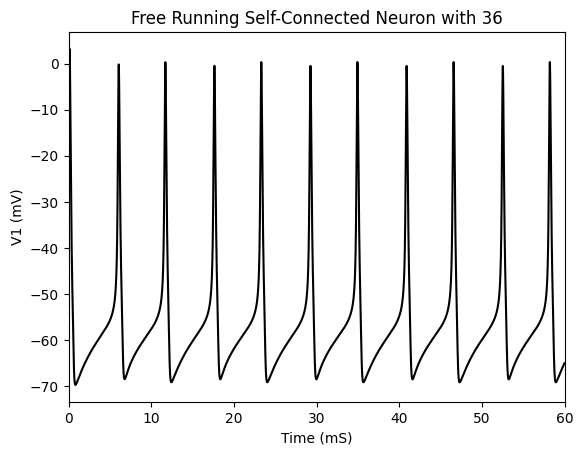

In [11]:
h = 0.001 #h = 0.001#step size for the Runge Kutta Formulation 
tf = 60
N = tf/h
N = int(N)
print(N)
t = np.linspace(0,tf,N+1)

initial_values = [-30.00000, 0.184178, 0.582675, 0.399928, 0.465379, 0.00, 0.00]
#sol = ODE_Routine(initial_values,tf,h)
sol = ODE_Routine_Perturb(initial_values,tf,h,DELAY)

V1 = np.zeros(N+1)


j = 0
i = 0
print(len(sol))
print(i,j)
for i in range(len(sol)):
    #print('i of rows each time',sol[i][0])
    V1[j] = sol[i][0]
    j = j+1
    
itemindex = np.where(V1[:] >= THRESHOLD)
#print(itemindex)

for index in itemindex:
    spike_times = t[index]
    
#print(spike_times)

previous = spike_times[0]
actual_spikes = []
actual_spikes.append(previous)   
for i in range(len(spike_times)):
    if (spike_times[i] - previous > 1 ):
        actual_spikes.append(spike_times[i])
    previous = spike_times[i]

free_running_36 = actual_spikes
print('The spike times of a free running neuron are',free_running_36)

difference = []

initial = actual_spikes[0]
for spikes in actual_spikes:
    difference.append(round(spikes - initial,4))
    initial = spikes

length_36 = []

for j in range(len(difference)):
    if(j>0):length_36.append(difference[j])

print('Free running period is', length_36)

#print('Free running period is', length_free)

plt.figure()
plt.title('Free Running Self-Connected Neuron with 36')
plt.plot(t,V1, 'k', label='V1')
plt.ylabel('V1 (mV)')
plt.xlabel('Time (mS)')
plt.xlim([0, tf])

In [12]:
T1 = free_running_36[5]
T2 = free_running_36[6]
#T3 = free_running_single[8]
#print(T1,T2)
period_free_36 = T2-T1
print(period_free_36)
epsilon = 0.01
#prc_interval = np.arange(T1+epsilon, T2-epsilon, epsilon)
prc_interval_36 = np.linspace(T1+epsilon, T2, 100)
stim_interval = prc_interval_36 - T1
#print(prc_interval_single)
phase_36 = stim_interval/period_free_36

prc_readings_36 = np.zeros((len(prc_interval_36),1))
output_36 = np.zeros((len(prc_interval_36),2))

j=0
for ts in prc_interval_36:
    h = 0.0001 #h = 0.001#step size for the Runge Kutta Formulation 
    tf = 60
    N = tf/h
    N = int(N)
    #print(N)
    t = np.linspace(0,tf,N+1)
    
    initial_values = [-30.00000, 0.184178, 0.582675, 0.399928, 0.465379, 0.00, 0.00]
    sol = ODE_Routine_Perturb(initial_values,tf,h,ts)
    V1 = np.zeros(N+1)
    k = 0
    for i in range(len(sol)):
        #print('i of rows each time',sol[i][0])
        V1[k] = sol[i][0]
        #print(V1[k])
        k = k+1
    
    itemindex = np.where(V1[:] > THRESHOLD)
    
    for index in itemindex:
        spike_times = t[index]
        
    previous = spike_times[0]
    actual_spikes = []
    actual_spikes.append(previous)   
    for i in range(len(spike_times)):
        if (spike_times[i] - previous > 1 ):
            actual_spikes.append(spike_times[i])
        previous = spike_times[i]
    #print(j,ts,actual_spikes)
    #diff_timings = np.zeros(len(actual_spikes))
    #for p in range(len(actual_spikes) - 1):
        #print(p,actual_spikes[p+1] - actual_spikes[p],free_running_self[p+1] - free_running_self[p])
    diff_timings = (actual_spikes[6] - actual_spikes[5]) - (free_running_36[6] - free_running_36[5])
    #print(diff_timings,diff_timings.shape)

    
    #print(phase_self[j],diff_timings[2:5]/period_free)
    #prc_readings.append(diff_timings)
    prc_readings_36[j,:] = diff_timings
    output_36[j,0] = phase_36[j]
    output_36[j,1:] = diff_timings/period_free_36
    print(output_36[j,:])
    j = j+1

prc_readings_36 = prc_readings_36/period_free_36
#print('The final readings required for the PRC are:',prc_readings_36)
#print(prc_readings.shape)
#print(phase.shape

#df = pd.DataFrame(output_single, columns=['Phase', 'First_Order', 'Second_Order', 'Third_Order'])
#df.to_excel('02. PRC_Self2Single_Hyper.xlsx', sheet_name='Network Perturbation')

5.683000000000003
[ 0.00175963 -0.00272743]
[ 0.01184287 -0.00295619]
[ 0.02192611 -0.00320253]
[ 0.03200934 -0.00346648]
[ 0.04209258 -0.00374802]
[ 0.05217581 -0.00406475]
[ 0.06225905 -0.00439908]
[ 0.07234229 -0.00475101]
[ 0.08242552 -0.00510294]
[ 0.09250876 -0.00545487]
[ 0.10259199 -0.0057892 ]
[ 0.11267523 -0.00607074]
[ 0.12275847 -0.00629949]
[ 0.1328417  -0.00647545]
[ 0.14292494 -0.00659863]
[ 0.15300817 -0.00668661]
[ 0.16309141 -0.00677459]
[ 0.17317465 -0.00682738]
[ 0.18325788 -0.00688017]
[ 0.19334112 -0.00693296]
[ 0.20342435 -0.00698575]
[ 0.21350759 -0.00703854]
[ 0.22359083 -0.00707373]
[ 0.23367406 -0.00710892]
[ 0.2437573  -0.00716171]
[ 0.25384053 -0.0071969 ]
[ 0.26392377 -0.0072145 ]
[ 0.27400701 -0.00724969]
[ 0.28409024 -0.00728488]
[ 0.29417348 -0.00730248]
[ 0.30425671 -0.00732008]
[ 0.31433995 -0.00733767]
[ 0.32442319 -0.00733767]
[ 0.33450642 -0.00735527]
[ 0.34458966 -0.00735527]
[ 0.35467289 -0.00733767]
[ 0.36475613 -0.00733767]
[ 0.37483937 -0.0073

(0.0, 1.0)

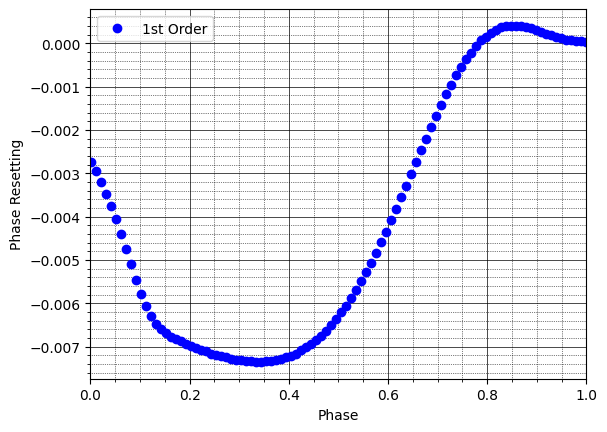

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
#plt.title('PRCs for Single due to Network with delay of 5.1ms')
plt.plot(phase_36, prc_readings_36, 'bo', label='1st Order')
#plt.axvline(x = (4.2/7.202),color='k',linestyle='--')
plt.ylabel('Phase Resetting')
plt.xlabel('Phase')
#plt.savefig('PRC_Single.eps', format='eps')
plt.legend()


ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlim([0, 1])


In [14]:
df = pd.DataFrame(output_36, columns=['Phase', 'First_Order'])
df.to_excel('57.Single2Self5P7.xlsx', sheet_name='Single2Self_1to24')

(0.0, 1.0)

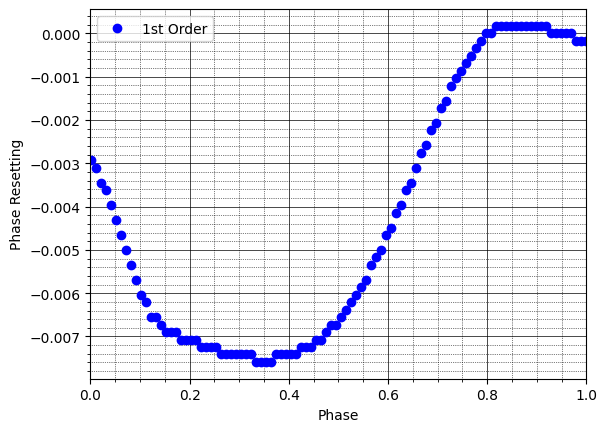

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
#plt.title('PRCs for Single due to Network with delay of 5.1ms')
plt.plot(phase_36, prc_readings_36, 'bo', label='1st Order')
#plt.axvline(x = (4.2/7.202),color='k',linestyle='--')
plt.ylabel('Phase Resetting')
plt.xlabel('Phase')
#plt.savefig('PRC_Single.eps', format='eps')
plt.legend()


ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlim([0, 1])





#df = pd.DataFrame(output_single, columns=['Phase', 'First_Order'])
#df.to_excel('03.Single2SelfP3.xlsx', sheet_name='Single2Self_1to8')